In [2]:
# ref: Effect of BCI-Controlled Pedaling Training System With Multiple Modalities
# of Feedback on Motor and Cognitive Function Rehabilitation of Early Subacute Stroke Patients

# Alpha -> 7 - 13 Hz (pequena diferença com o protocolo cognitivo (8-13 Hz))
# Beta -> 14 - 30 Hz (pequena diferença com o protocolo cognitivo (13-30 Hz))
# Gama -> 30 Hz

# Taxa de amostragem 500Hz = fs

# β/α a cada 2 seg (grafico em função do tempo)

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt # Filtro Butterworth
from scipy.fft import rfft, rfftfreq # Fast Fourier transform


In [3]:
fs = 500
duracao = 2  # segundos
t = np.arange(0, duracao, 1/fs) # Vetor de tempo

# Gerando as componentes (Senoide: Amplitude * sin(2*pi*frequencia*tempo))
sinal_alfa = 1.0 * np.sin(2 * np.pi * 10 * t)  # 10 Hz (Alfa: 7 - 13 Hz)
sinal_beta = 0.5 * np.sin(2 * np.pi * 20 * t)  # 20 Hz (Beta: 14 - 30 Hz)

# Gerando ruído branco (distribuição normal)
ruido = np.random.normal(0, 0.8, len(t))

# Sinal EEG Sintético (Soma de tudo)
eeg_raw = sinal_alfa + sinal_beta + ruido

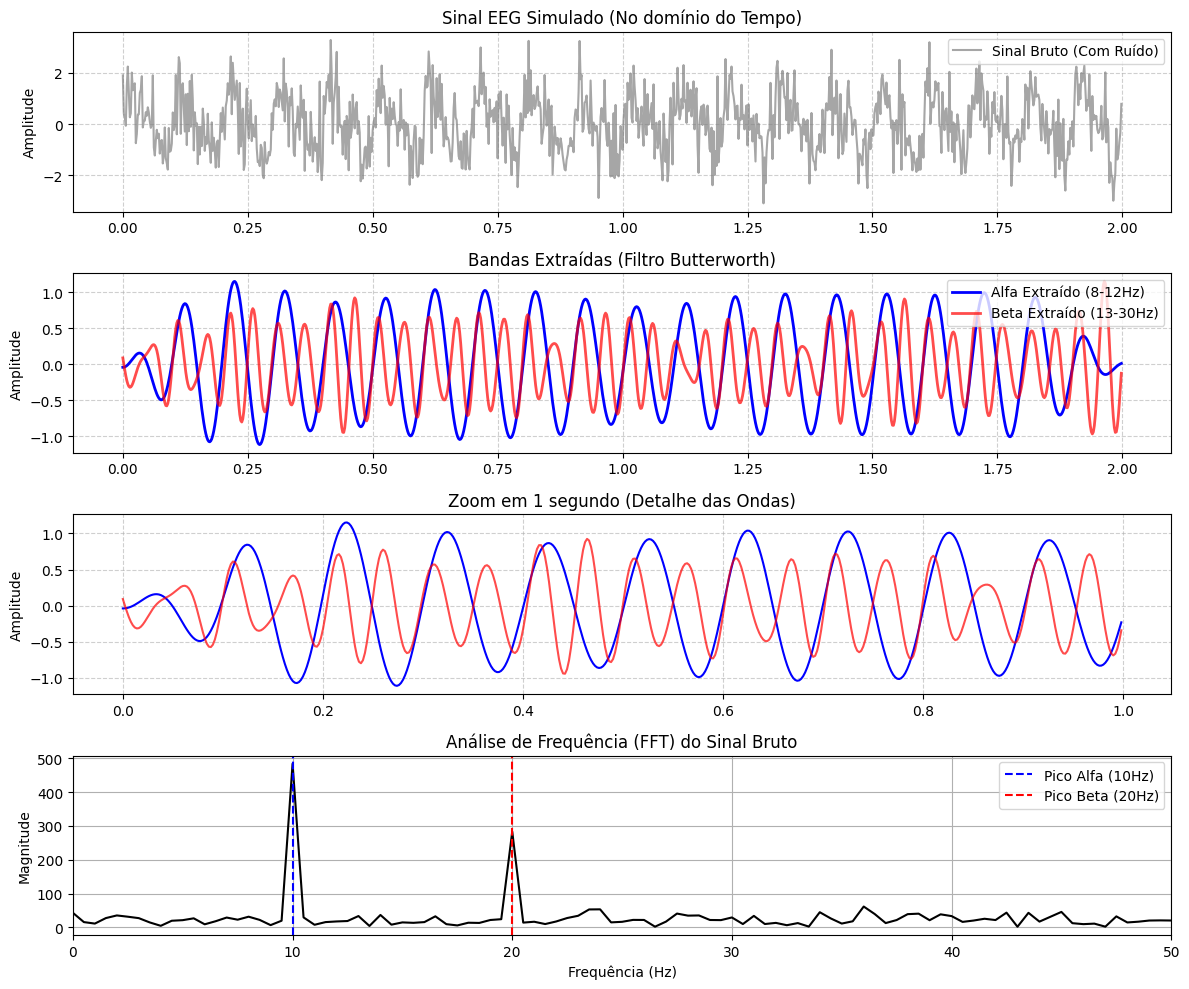

In [4]:

# --- FUNÇÃO DE FILTRAGEM (BUTTERWORTH) ---

def aplicar_filtro_bandpass(dados, lowcut, highcut, fs, ordem=4):
    """
    Cria e aplica um filtro passa-faixa (Bandpass).
    Isso 'deixa passar' apenas as frequências entre lowcut e highcut.
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist

    # Design do filtro (b, a são coeficientes)
    b, a = butter(ordem, [low, high], btype='band')

    # Aplica o filtro usando filtfilt (filtfilt aplica 2x para fase zero)
    y = filtfilt(b, a, dados)
    return y

# --- 3. EXTRAÇÃO DAS BANDAS ---

# Extraindo Alfa (8-12 Hz)
eeg_alfa_filtrado = aplicar_filtro_bandpass(eeg_raw, 7, 13, fs)

# Extraindo Beta (13-30 Hz)
eeg_beta_filtrado = aplicar_filtro_bandpass(eeg_raw, 14, 30, fs)

# --- 4. ANÁLISE DE FREQUÊNCIA (FFT) ---
# Vamos usar a FFT para "provar" que o filtro funcionou vendo o espectro

# FFT do sinal original
N = len(eeg_raw)
yf = rfft(eeg_raw)
xf = rfftfreq(N, 1/fs)

# --- 5. VISUALIZAÇÃO (PLOT) ---

plt.figure(figsize=(12, 10))

# Plot 1: Sinal Original (Tempo)
plt.subplot(4, 1, 1)
plt.plot(t, eeg_raw, color='gray', alpha=0.7, label='Sinal Bruto (Com Ruído)')
plt.title('Sinal EEG Simulado (No domínio do Tempo)')
plt.ylabel('Amplitude')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)

# Plot 2: Bandas Filtradas (Tempo)
plt.subplot(4, 1, 2)
plt.plot(t, eeg_alfa_filtrado, label='Alfa Extraído (8-12Hz)', color='blue', linewidth=2)
plt.plot(t, eeg_beta_filtrado, label='Beta Extraído (13-30Hz)', color='red', linewidth=2, alpha=0.7)
plt.title('Bandas Extraídas (Filtro Butterworth)')
plt.ylabel('Amplitude')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)

# Plot 3: Zoom em 1 segundo (para ver a forma da onda melhor)
plt.subplot(4, 1, 3)
plt.plot(t[:fs], eeg_alfa_filtrado[:fs], label='Alfa Zoom', color='blue')
plt.plot(t[:fs], eeg_beta_filtrado[:fs], label='Beta Zoom', color='red', alpha=0.7)
plt.title('Zoom em 1 segundo (Detalhe das Ondas)')
plt.ylabel('Amplitude')
plt.grid(True, linestyle='--', alpha=0.6)

# Plot 4: Espectro de Frequência (FFT)
plt.subplot(4, 1, 4)
plt.plot(xf, np.abs(yf), color='black')
plt.title('Análise de Frequência (FFT) do Sinal Bruto')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, 50) # Focando até 50Hz pois é onde está nosso sinal
plt.axvline(x=10, color='blue', linestyle='--', label='Pico Alfa (10Hz)')
plt.axvline(x=20, color='red', linestyle='--', label='Pico Beta (20Hz)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Análise de Dados Reais - Dataset sub-001

## Estrutura dos Dados

O dataset usa o formato **BrainVision** (.vhdr, .eeg, .vmrk):
- **Taxa de amostragem**: 500 Hz
- **Canais**: 27 EEG + 3 EOG
- **Tarefas**: flanker, visualoddball, visualsearch

O objetivo é sar os dados reais e calcular a razão β/α em janelas de tempo.

In [11]:
# Instalar MNE se necessário
# !pip install mne

import mne
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.fft import rfft, rfftfreq

# Configurações
mne.set_log_level('WARNING')  # Reduzir mensagens de log

In [12]:
# --- 1. CARREGAR DADOS REAIS DO PACIENTE SUB-001 ---

# Caminho para os arquivos (tarefa flanker como exemplo)
vhdr_file = r'../datasets/ds005863/sub-001/eeg/sub-001_task-flanker_eeg.vhdr'

# Carregar dados brutos usando MNE
raw = mne.io.read_raw_brainvision(vhdr_file, preload=True)

# Informações básicas
print(f"Taxa de amostragem: {raw.info['sfreq']} Hz")
print(f"Duração: {raw.times[-1]:.2f} segundos")
print(f"Número de canais: {len(raw.ch_names)}")
print(f"Canais EEG: {raw.copy().pick_types(eeg=True).ch_names}")

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\felip\\OneDrive\\Documentos\\GitHub\\EEG_Studies\\datasets\\ds005863\\sub-001\\eeg\\sub-001_task-flanker_eeg.vhdr'

In [ ]:
# --- 2. SELECIONAR UM CANAL PARA ANÁLISE ---
# Vamos usar o canal 'Cz' (central, bom para análise de ritmos cerebrais)

canal = 'Cz'
fs = raw.info['sfreq']  # 500 Hz

# Extrair dados do canal
dados_canal = raw.get_data(picks=[canal])[0]

print(f"Canal selecionado: {canal}")
print(f"Comprimento do sinal: {len(dados_canal)} amostras")
print(f"Tempo total: {len(dados_canal)/fs:.2f} segundos")

In [ ]:
# --- 3. FUNÇÃO DE FILTRAGEM BUTTERWORTH ---

def aplicar_filtro_bandpass(dados, lowcut, highcut, fs, ordem=4):
    """
    Aplica filtro passa-faixa Butterworth.
    
    Parâmetros:
    - dados: sinal de entrada
    - lowcut: frequência de corte inferior (Hz)
    - highcut: frequência de corte superior (Hz)
    - fs: taxa de amostragem (Hz)
    - ordem: ordem do filtro
    
    Retorna:
    - sinal filtrado
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    
    b, a = butter(ordem, [low, high], btype='band')
    y = filtfilt(b, a, dados)
    return y

In [ ]:
# --- 4. APLICAR FILTROS PARA EXTRAIR BANDAS ALFA E BETA ---

# Protocolo do artigo:
# Alfa: 7-13 Hz (ou 8-13 Hz no protocolo cognitivo)
# Beta: 14-30 Hz (ou 13-30 Hz no protocolo cognitivo)

# Filtrando banda Alfa (8-13 Hz)
dados_alfa = aplicar_filtro_bandpass(dados_canal, 8, 13, fs, ordem=4)

# Filtrando banda Beta (13-30 Hz)
dados_beta = aplicar_filtro_bandpass(dados_canal, 13, 30, fs, ordem=4)

print("Filtros aplicados com sucesso!")
print(f"Banda Alfa: 8-13 Hz")
print(f"Banda Beta: 13-30 Hz")

In [ ]:
# --- 5. CALCULAR POTÊNCIA EM JANELAS DE TEMPO (2 SEGUNDOS) ---

def calcular_potencia_janelada(dados, tamanho_janela, fs):
    """
    Calcula a potência do sinal em janelas de tempo.
    
    Parâmetros:
    - dados: sinal filtrado
    - tamanho_janela: duração da janela em segundos
    - fs: taxa de amostragem
    
    Retorna:
    - vetor de tempo (centro de cada janela)
    - vetor de potência (média quadrática em cada janela)
    """
    amostras_janela = int(tamanho_janela * fs)
    num_janelas = len(dados) // amostras_janela
    
    tempo_janelas = []
    potencia_janelas = []
    
    for i in range(num_janelas):
        inicio = i * amostras_janela
        fim = inicio + amostras_janela
        janela = dados[inicio:fim]
        
        # Potência = RMS (Root Mean Square) ao quadrado
        potencia = np.mean(janela ** 2)
        tempo_centro = (inicio + fim) / (2 * fs)
        
        potencia_janelas.append(potencia)
        tempo_janelas.append(tempo_centro)
    
    return np.array(tempo_janelas), np.array(potencia_janelas)

# Janelas de 2 segundos (conforme o protocolo)
tamanho_janela = 2.0

tempo_alfa, potencia_alfa = calcular_potencia_janelada(dados_alfa, tamanho_janela, fs)
tempo_beta, potencia_beta = calcular_potencia_janelada(dados_beta, tamanho_janela, fs)

print(f"Número de janelas de {tamanho_janela}s: {len(tempo_alfa)}")
print(f"Duração total analisada: {tempo_alfa[-1]:.2f} segundos")

In [ ]:
# --- 6. CALCULAR A RAZÃO β/α ---

# Razão Beta/Alfa em cada janela de tempo
razao_beta_alfa = potencia_beta / (potencia_alfa + 1e-10)  # +1e-10 para evitar divisão por zero

print(f"Razão β/α calculada para {len(razao_beta_alfa)} janelas")
print(f"Média da razão β/α: {np.mean(razao_beta_alfa):.3f}")
print(f"Desvio padrão: {np.std(razao_beta_alfa):.3f}")
print(f"Mín: {np.min(razao_beta_alfa):.3f}, Máx: {np.max(razao_beta_alfa):.3f}")

In [ ]:
# --- 7. VISUALIZAÇÃO COMPLETA ---

fig = plt.figure(figsize=(14, 12))

# Plot 1: Sinal original (primeiros 10 segundos)
plt.subplot(5, 1, 1)
tempo_plot = np.arange(0, min(10*fs, len(dados_canal))) / fs
plt.plot(tempo_plot, dados_canal[:len(tempo_plot)], color='black', alpha=0.7)
plt.title(f'Sinal EEG Bruto - Canal {canal} (primeiros 10s)', fontsize=12, fontweight='bold')
plt.ylabel('Amplitude (μV)')
plt.xlabel('Tempo (s)')
plt.grid(True, alpha=0.3)

# Plot 2: Banda Alfa filtrada
plt.subplot(5, 1, 2)
plt.plot(tempo_plot, dados_alfa[:len(tempo_plot)], color='blue', linewidth=1.5)
plt.title('Banda Alfa Filtrada (8-13 Hz)', fontsize=12, fontweight='bold')
plt.ylabel('Amplitude (μV)')
plt.xlabel('Tempo (s)')
plt.grid(True, alpha=0.3)

# Plot 3: Banda Beta filtrada
plt.subplot(5, 1, 3)
plt.plot(tempo_plot, dados_beta[:len(tempo_plot)], color='red', linewidth=1.5)
plt.title('Banda Beta Filtrada (13-30 Hz)', fontsize=12, fontweight='bold')
plt.ylabel('Amplitude (μV)')
plt.xlabel('Tempo (s)')
plt.grid(True, alpha=0.3)

# Plot 4: Potência das bandas em função do tempo
plt.subplot(5, 1, 4)
plt.plot(tempo_alfa, potencia_alfa, 'o-', color='blue', label='Potência Alfa', linewidth=2, markersize=4)
plt.plot(tempo_beta, potencia_beta, 's-', color='red', label='Potência Beta', linewidth=2, markersize=4)
plt.title('Potência das Bandas (Janelas de 2s)', fontsize=12, fontweight='bold')
plt.ylabel('Potência (μV²)')
plt.xlabel('Tempo (s)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 5: Razão β/α em função do tempo
plt.subplot(5, 1, 5)
plt.plot(tempo_alfa, razao_beta_alfa, 'o-', color='purple', linewidth=2, markersize=5)
plt.axhline(y=np.mean(razao_beta_alfa), color='green', linestyle='--', 
            label=f'Média = {np.mean(razao_beta_alfa):.3f}', linewidth=2)
plt.title('Razão β/α ao longo do tempo (Janelas de 2s)', fontsize=12, fontweight='bold')
plt.ylabel('Razão β/α')
plt.xlabel('Tempo (s)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Análise Espectral (FFT) - Comparação com Sinal Simulado

Vamos usar FFT para verificar o espectro de frequência do sinal real e confirmar que os filtros estão funcionando corretamente.

In [ ]:
# --- 8. ANÁLISE ESPECTRAL (FFT) ---

# Usar uma janela de 10 segundos para FFT
janela_fft = int(10 * fs)
dados_fft = dados_canal[:janela_fft]

# Calcular FFT
N = len(dados_fft)
yf = rfft(dados_fft)
xf = rfftfreq(N, 1/fs)

# FFT das bandas filtradas
yf_alfa = rfft(dados_alfa[:janela_fft])
yf_beta = rfft(dados_beta[:janela_fft])

# Visualização do espectro
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Espectro do sinal original
axes[0].plot(xf, np.abs(yf), color='black', linewidth=1)
axes[0].set_title('Espectro de Frequência - Sinal Original', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Magnitude')
axes[0].set_xlim(0, 50)
axes[0].axvspan(8, 13, alpha=0.2, color='blue', label='Banda Alfa (8-13 Hz)')
axes[0].axvspan(13, 30, alpha=0.2, color='red', label='Banda Beta (13-30 Hz)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Espectro da banda Alfa
axes[1].plot(xf, np.abs(yf_alfa), color='blue', linewidth=1.5)
axes[1].set_title('Espectro de Frequência - Banda Alfa Filtrada', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Magnitude')
axes[1].set_xlim(0, 50)
axes[1].axvspan(8, 13, alpha=0.2, color='blue')
axes[1].grid(True, alpha=0.3)

# Espectro da banda Beta
axes[2].plot(xf, np.abs(yf_beta), color='red', linewidth=1.5)
axes[2].set_title('Espectro de Frequência - Banda Beta Filtrada', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Magnitude')
axes[2].set_xlabel('Frequência (Hz)')
axes[2].set_xlim(0, 50)
axes[2].axvspan(13, 30, alpha=0.2, color='red')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Análise de Eventos

Os arquivos `.tsv` contêm marcadores temporais dos eventos experimentais. Vamos visualizar como a razão β/α varia em relação aos eventos.

In [ ]:
# --- 9. CARREGAR E VISUALIZAR EVENTOS ---

# Carregar eventos do arquivo .tsv
import pandas as pd

events_file = r'../datasets/ds005863/sub-001/eeg/sub-001_task-flanker_events.tsv'
events_df = pd.read_csv(events_file, sep='\t')

print(f"Total de eventos: {len(events_df)}")
print(f"\nPrimeiros eventos:")
print(events_df.head(10))

# Tipos de eventos únicos
print(f"\nTipos de eventos: {events_df['value'].unique()}")

In [ ]:
# --- 10. VISUALIZAR RAZÃO β/α COM EVENTOS SOBREPOSTOS ---

# Filtrar apenas eventos de estímulo (excluir boundary e respostas)
eventos_estimulo = events_df[events_df['value'].str.contains(r'^\s*\d{1,2}\s*$', regex=True, na=False)]

plt.figure(figsize=(14, 6))
plt.plot(tempo_alfa, razao_beta_alfa, 'o-', color='purple', linewidth=2, markersize=5, label='Razão β/α')
plt.axhline(y=np.mean(razao_beta_alfa), color='green', linestyle='--', 
            label=f'Média = {np.mean(razao_beta_alfa):.3f}', linewidth=2)

# Plotar marcadores de eventos
for idx, evento in eventos_estimulo.iterrows():
    tempo_evento = evento['onset']
    if tempo_evento < tempo_alfa[-1]:
        plt.axvline(x=tempo_evento, color='red', alpha=0.3, linewidth=0.5)

plt.title('Razão β/α com Eventos da Tarefa Flanker', fontsize=14, fontweight='bold')
plt.ylabel('Razão β/α', fontsize=12)
plt.xlabel('Tempo (s)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nLinhas vermelhas verticais indicam eventos da tarefa (estímulos apresentados)")

## Resumo do Pipeline

### **Fluxo de processamento implementado:**

1. **Carregamento**: Dados EEG em formato BrainVision (.vhdr)
2. **Filtragem**: Butterworth passa-faixa para Alfa (8-13 Hz) e Beta (13-30 Hz)
3. **Janelamento**: Divisão em janelas de 2 segundos
4. **Cálculo de Potência**: RMS² para cada janela
5. **Razão β/α**: Divisão Beta/Alfa em cada janela temporal
6. **Validação**: FFT para confirmar frequências extraídas
7. **Visualização**: Integração com eventos experimentais

### **Parâmetros utilizados:**
- Taxa de amostragem: 500 Hz
- Canal analisado: Cz (região central)
- Janela temporal: 2 segundos
- Filtro: Butterworth ordem 4